In [1]:
import pandas as pd
import import_ipynb
import analysis_utils as utils
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

importing Jupyter notebook from analysis_utils.ipynb


In [2]:
# Set oandas formating options
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.width = 2000
pd.options.display.max_columns = 10

In [3]:
# 1. load airbnb data using UDF
data_type = ['calendar'
             , 'listings'
             , 'reviews']

city_type = ['seattle'
             , 'boston']

city_dictionary = utils.load_csv(city_type, data_type, 'data')

In [4]:
# 2. create separate dataframes for each city and data set
reviews_df = utils.concatenate_dataframes(city_dictionary, 'reviews')
calendar_df = utils.concatenate_dataframes(city_dictionary, 'calendar')
listings_df = utils.concatenate_dataframes(city_dictionary, 'listings')

In [5]:
# 3.  check shape of the listings df
print(listings_df[listings_df['boston'] == 1].shape)
print(listings_df[listings_df['boston'] == 0].shape)
# seattle has slighlty more observations

(3585, 99)
(3818, 99)


In [6]:
# 4. check missing data
# create a list of columns that have more than 50% of missing data to drop then later
columns_with_missing_values = utils.check_missing_values(listings_df, 0.5)

                            index  seattle  boston
63                        license     1.00    1.00
11             jurisdiction_names     0.00    1.00
77   neighbourhood_group_cleansed     0.00    1.00
81               has_availability     0.00    1.00
41                    square_feet     0.97    0.98
73            monthly_price_float     0.60    0.75
85                  monthly_price     0.60    0.75
14                   weekly_price     0.47    0.75
67             weekly_price_float     0.47    0.75
71               security_deposit     0.51    0.63
27                          notes     0.42    0.55
54          neighborhood_overview     0.27    0.39
69                     host_about     0.22    0.37
96                        transit     0.24    0.36
52                   cleaning_fee     0.27    0.31
65                          space     0.15    0.29
86         review_scores_accuracy     0.17    0.23
51         review_scores_location     0.17    0.23
92            review_scores_val

In [7]:
# Check missing data in categorical series
string_columns = list(set(listings_df.select_dtypes(include=['object']).columns)) + ['boston']
utils.check_missing_values(listings_df[string_columns], 0.5)

                               index  seattle  boston
11      neighbourhood_group_cleansed     0.00    1.00
18                  has_availability     0.00    1.00
32                jurisdiction_names     0.00    1.00
21                     monthly_price     0.60    0.75
37                      weekly_price     0.47    0.75
1                   security_deposit     0.51    0.63
0                              notes     0.42    0.55
64             neighborhood_overview     0.27    0.39
59                        host_about     0.22    0.37
56                           transit     0.24    0.36
61                      cleaning_fee     0.27    0.31
38                             space     0.15    0.29
20                      first_review     0.16    0.21
22                       last_review     0.16    0.21
9                     xl_picture_url     0.08    0.17
12                     thumbnail_url     0.08    0.17
25                        medium_url     0.08    0.17
53                     neigh

['neighbourhood_group_cleansed',
 'has_availability',
 'jurisdiction_names',
 'monthly_price',
 'weekly_price',
 'security_deposit',
 'notes']

In [8]:
# Check missing data in numerical series
numeric_columns = list(set(listings_df.select_dtypes(include=['int64','float64']).columns))
utils.check_missing_values(listings_df[numeric_columns], 0.5)

                             index  seattle  boston
16                         license     1.00    1.00
22                     square_feet     0.97    0.98
1              monthly_price_float     0.60    0.75
28              weekly_price_float     0.47    0.75
13          review_scores_accuracy     0.17    0.23
33          review_scores_location     0.17    0.23
27             review_scores_value     0.17    0.23
32           review_scores_checkin     0.17    0.23
8        review_scores_cleanliness     0.17    0.23
3      review_scores_communication     0.17    0.23
10            review_scores_rating     0.17    0.23
12               reviews_per_month     0.16    0.21
29                       bathrooms     0.00    0.00
7                         bedrooms     0.00    0.00
19                            beds     0.00    0.00
21       host_total_listings_count     0.00    0.00
30             host_listings_count     0.00    0.00
0                number_of_reviews     0.00    0.00
2           

['license', 'square_feet', 'monthly_price_float', 'weekly_price_float']

In [9]:
# 5. drop url and scrapping related columns
listings_df = utils.drop_specified_columns('url', listings_df)
listings_df = utils.drop_specified_columns('scrap', listings_df)

In [10]:
# 6. drop columns that have more than 50% of data missing
listings_df = listings_df.drop(columns=columns_with_missing_values)

In [11]:
# 7. check if price_float has missing colums
listings_df['price_float'].isnull().sum()

0

In [12]:
# 8. drop non informative columns
exclude_columns = ['id'
                , 'host_id'
                , 'host_listings_count'
                , 'host_total_listings_count'
                , 'latitude'
                , 'longitude'
                , 'last_review'
                , 'first_review'
                , 'summary'
                , 'zipcode'
                , 'host_location'
                , 'state'
                , 'country'
                , 'market']
listings_df = listings_df.drop(columns=exclude_columns)

In [13]:
# 8. check missing values after droping missing values
columns_with_missing_values = utils.check_missing_values(listings_df, 0.5)

                               index  seattle  boston
34             neighborhood_overview     0.27    0.39
45                        host_about     0.22    0.37
61                           transit     0.24    0.36
32                      cleaning_fee     0.27    0.31
42                             space     0.15    0.29
52            review_scores_accuracy     0.17    0.23
31            review_scores_location     0.17    0.23
57               review_scores_value     0.17    0.23
14             review_scores_checkin     0.17    0.23
4          review_scores_cleanliness     0.17    0.23
1        review_scores_communication     0.17    0.23
50              review_scores_rating     0.17    0.23
7                  reviews_per_month     0.16    0.21
29                     neighbourhood     0.11    0.15
46              host_acceptance_rate     0.20    0.13
2                 host_response_time     0.14    0.13
39                host_response_rate     0.14    0.13
24                host_neigh

In [14]:
# 9. Convert host_since_year to numetic value
listings_df['host_since_year'] = pd.to_numeric(listings_df['host_since_year'], errors='coerce')

In [15]:
# 10. describe float columns in both cities
utils.compare_all_float_columns(listings_df)
#Boston has larger minimum_nights mean
#Boston has lower review scores mean
#Boston has higher mean price
#Boston has less beds mean


 Describe review_scores_communication
   index  review_scores_communication_seattle  review_scores_communication-boston
0  count                              3167.00                             2767.00
1   mean                                 9.81                                9.65
2    std                                 0.57                                0.74
3    min                                 2.00                                4.00
4    25%                                10.00                                9.00
5    50%                                10.00                               10.00
6    75%                                10.00                               10.00
7    max                                10.00                               10.00

 Describe bedrooms
   index  bedrooms_seattle  bedrooms-boston
0  count           3812.00          3575.00
1   mean              1.31             1.26
2    std              0.88             0.75
3    min              0.00 

                             mean-seattle  mean-boston
minimum_nights                       2.37         3.17
bedrooms                             1.31         1.26
bathrooms                            1.26         1.22
guests_included                      1.67         1.43
accommodates                         3.35         3.04
review_scores_communication          9.81         9.65
review_scores_cleanliness            9.56         9.26
reviews_per_month                    2.08         1.97
review_scores_checkin                9.79         9.65
number_of_reviews                   22.22        19.04
review_scores_location               9.61         9.41
review_scores_accuracy               9.64         9.43
review_scores_value                  9.45         9.17


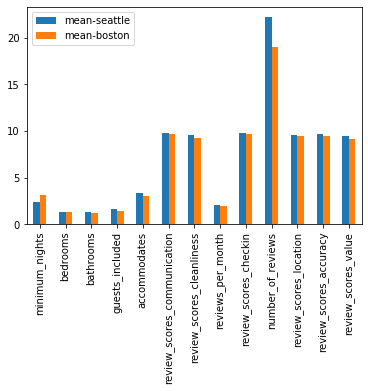

             mean-seattle  mean-boston
price_float        127.98       173.93


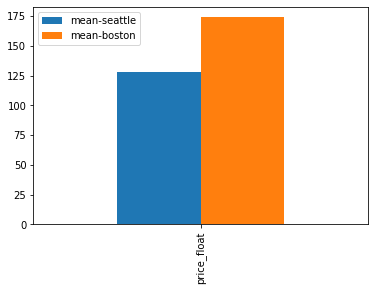

                      mean-seattle  mean-boston
review_scores_rating         94.54        91.92


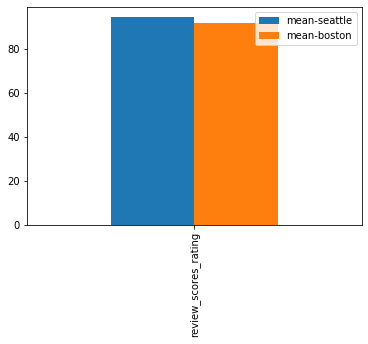

In [16]:
# 11. summarize price, reviews and property attributes in a single summary
review_columns = [col for col in listings_df.columns if 'review' in col] 
specific_columns = ['minimum_nights'
                   , 'bedrooms'
                   , 'bathrooms'
                   , 'guests_included'
                   , 'accommodates']
numeric_columns_to_describe = specific_columns + review_columns
numeric_columns_to_describe.remove('review_scores_rating')
utils.compare_specified_float_columns(listings_df, numeric_columns_to_describe, 'mean')
utils.compare_specified_float_columns(listings_df, ['price_float'], 'mean')
utils.compare_specified_float_columns(listings_df, ['review_scores_rating'], 'mean')
# create list of numeric columns to use in analysis
numeric_columns_to_describe = numeric_columns_to_describe + ['host_since_year', 'review_scores_rating']
# Price mean is higher in Boston but raitings mean is higher in Seattle

In [17]:
# 12. check missing values in particular columns
utils.check_missing_values(listings_df[['boston', 'price_float'] + numeric_columns_to_describe], 0.5)
# there is at most 23% if missing values in boston and 17 in seattle 
# so it is reasonable to cure this data with mean values

                          index  seattle  boston
13       review_scores_accuracy     0.17    0.23
12       review_scores_location     0.17    0.23
14          review_scores_value     0.17    0.23
10        review_scores_checkin     0.17    0.23
8     review_scores_cleanliness     0.17    0.23
7   review_scores_communication     0.17    0.23
16         review_scores_rating     0.17    0.23
9             reviews_per_month     0.16    0.21
4                     bathrooms     0.00    0.00
3                      bedrooms     0.00    0.00
15              host_since_year     0.00    0.00
0                        boston     0.00    0.00
1                   price_float     0.00    0.00
2                minimum_nights     0.00    0.00
5               guests_included     0.00    0.00
6                  accommodates     0.00    0.00
11            number_of_reviews     0.00    0.00


[]

In [100]:
# 13. replace missing numeric values with mean values for each city
numeric_columns = listings_df.select_dtypes(include=['float64','int64']).columns
boston_listing_df = listings_df[listings_df['boston'] == 1].reset_index(drop=True)
seattle_listing_df = listings_df[listings_df['boston'] == 0].reset_index(drop=True)

def fillna_with_mean(numeric_series):
    """
    Function to fill nans of numeric series with its mean
    :param data: numeric series
    :return: numeric series with nans replaced by its mean
    """
    numeric_series = numeric_series.fillna(numeric_series.mean())
    return numeric_series

for col in numeric_columns:
    boston_listing_df[col] = fillna_with_mean(boston_listing_df[col])
    seattle_listing_df[col] = fillna_with_mean(seattle_listing_df[col])
filled_listings_df = pd.concat([boston_listing_df, seattle_listing_df]).reset_index(drop=True)

In [101]:
# 14. check that columns of interest have nulls filled
utils.check_missing_values(filled_listings_df[['boston', 'price_float'] + numeric_columns_to_describe], 0.5)  

                          index  seattle  boston
0                        boston     0.00    0.00
1                   price_float     0.00    0.00
2                minimum_nights     0.00    0.00
3                      bedrooms     0.00    0.00
4                     bathrooms     0.00    0.00
5               guests_included     0.00    0.00
6                  accommodates     0.00    0.00
7   review_scores_communication     0.00    0.00
8     review_scores_cleanliness     0.00    0.00
9             reviews_per_month     0.00    0.00
10        review_scores_checkin     0.00    0.00
11            number_of_reviews     0.00    0.00
12       review_scores_location     0.00    0.00
13       review_scores_accuracy     0.00    0.00
14          review_scores_value     0.00    0.00
15              host_since_year     0.00    0.00
16         review_scores_rating     0.00    0.00


[]

In [102]:
# 15. create list of string columns that have up to 6 different values in oder to make categorical predictors
values_freq = {}
for col in filled_listings_df.select_dtypes(include=['object']):
    values_freq[col] = len(filled_listings_df[col].drop_duplicates())
values_freq = {k: v for k, v in sorted(values_freq.items(), key=lambda item: item[1], reverse=False)}
print(values_freq)
# judjing by the amount of the distinct values in the categorical columns it makes sense to use only those with
# less of 6 distinct values as columns with more distinct values would create 
# a large amount of dimentions while not adding much to explanatory power
values_freq = {k: v for k, v in filter(lambda item: 1 < item[1] < 6, values_freq.items())}
categorical_columns_to_describe = set(values_freq.keys())
print(categorical_columns_to_describe)

{'experiences_offered': 1, 'requires_license': 1, 'country_code': 1, 'require_guest_profile_picture': 2, 'require_guest_phone_verification': 2, 'instant_bookable': 2, 'is_location_exact': 2, 'host_is_superhost': 3, 'room_type': 3, 'host_identity_verified': 3, 'host_has_profile_pic': 3, 'cancellation_policy': 4, 'host_response_time': 5, 'bed_type': 5, 'host_since_month': 13, 'property_type': 20, 'host_since_day': 32, 'calendar_updated': 38, 'smart_location': 46, 'city': 46, 'host_response_rate': 59, 'extra_people': 62, 'host_acceptance_rate': 73, 'neighbourhood_cleansed': 111, 'neighbourhood': 112, 'cleaning_fee': 133, 'host_verifications': 136, 'host_neighbourhood': 152, 'price': 366, 'host_since': 1846, 'host_name': 2348, 'street': 2681, 'host_about': 3251, 'neighborhood_overview': 4234, 'transit': 4433, 'space': 5388, 'amenities': 6310, 'description': 7165, 'name': 7296}
{'room_type', 'bed_type', 'host_response_time', 'require_guest_profile_picture', 'instant_bookable', 'host_identit

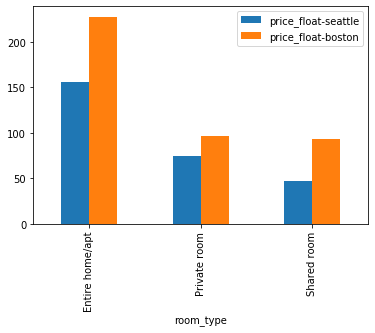

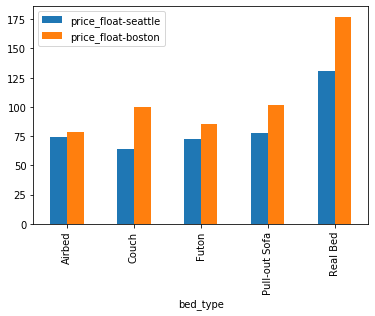

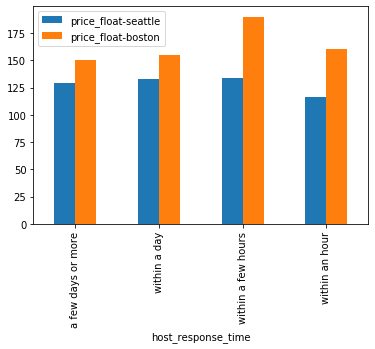

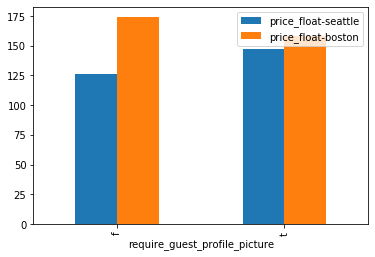

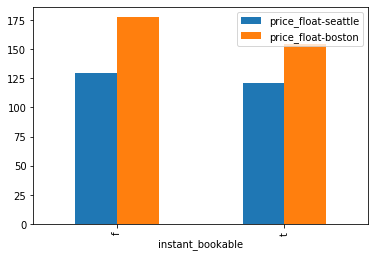

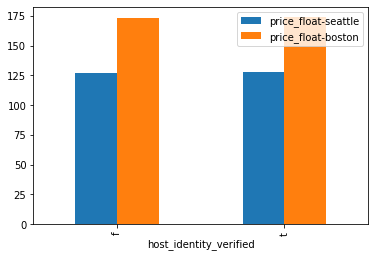

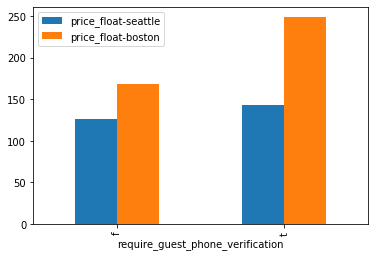

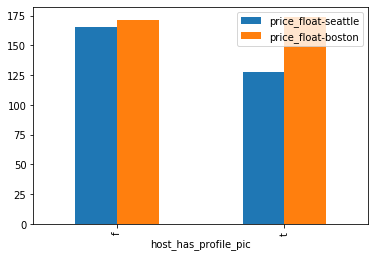

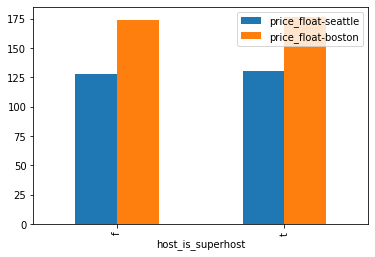

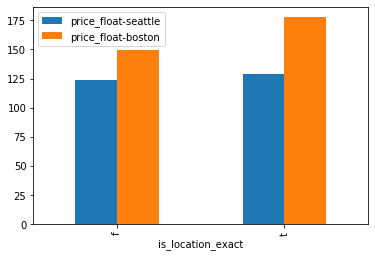

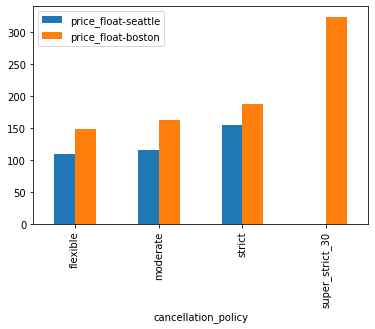

In [22]:
# 16. Compare numeric data across 2 cities grouping on each categorical column of interest
for col in categorical_columns_to_describe:
    utils.compare_grouby_results(filled_listings_df, [col], ['price_float'], 'mean')
#Boston has a premium for fast responses but not for the fastest
#Boston has super stric policy -> the stricter the policy the more expensive
#Super host has little effect
#Airbeds in seattle seem to be more appreciated than couches

In [96]:
# 17. keep only the columns of interest
filled_listings_df = filled_listings_df[['boston', 'price_float'] + list(numeric_columns_to_describe) + list(categorical_columns_to_describe)]

In [97]:
#Check the amount of.missing values
utils.check_missing_values(filled_listings_df, 0.5) 
# The only column that has missing values is host_response_time
# Only about 14% is missing from each city data
# Since I am interested in the impact of this variable in the price and there are only 14% of missing data 
# I can drop the records with missing data without loosing a lot of variation in the data
filled_cleaned_listings_df = filled_listings_df.dropna()
filled_cleaned_listings_df.shape

                               index  seattle  boston
19                host_response_time     0.14    0.13
22            host_identity_verified     0.00    0.00
24              host_has_profile_pic     0.00    0.00
25                 host_is_superhost     0.00    0.00
0                             boston     0.00    0.00
1                        price_float     0.00    0.00
2                     minimum_nights     0.00    0.00
3                           bedrooms     0.00    0.00
4                          bathrooms     0.00    0.00
5                    guests_included     0.00    0.00
6                       accommodates     0.00    0.00
7        review_scores_communication     0.00    0.00
8          review_scores_cleanliness     0.00    0.00
9                  reviews_per_month     0.00    0.00
10             review_scores_checkin     0.00    0.00
11                 number_of_reviews     0.00    0.00
12            review_scores_location     0.00    0.00
13            review_scores_

(6409, 28)

In [24]:
#18. create dummies for selected categorical variables
for col in categorical_columns_to_describe:
    # for each cat add dummy var, drop original column
    filled_cleaned_listings_df = pd.concat([filled_cleaned_listings_df.drop(col, axis=1)
                                        , pd.get_dummies(filled_cleaned_listings_df[col]
                                                         , prefix=col, prefix_sep='_', drop_first=True)], axis=1)
#drop super stric cancelation policy because it is only in boston
filled_cleaned_listings_df = filled_cleaned_listings_df.drop(columns=['cancellation_policy_super_strict_30'])
utils.check_missing_values(filled_cleaned_listings_df, 0.5) 


                                    index  seattle  boston
0                                  boston     0.00    0.00
1                             price_float     0.00    0.00
2                          minimum_nights     0.00    0.00
3                                bedrooms     0.00    0.00
4                               bathrooms     0.00    0.00
5                         guests_included     0.00    0.00
6                            accommodates     0.00    0.00
7             review_scores_communication     0.00    0.00
8               review_scores_cleanliness     0.00    0.00
9                       reviews_per_month     0.00    0.00
10                  review_scores_checkin     0.00    0.00
11                      number_of_reviews     0.00    0.00
12                 review_scores_location     0.00    0.00
13                 review_scores_accuracy     0.00    0.00
14                    review_scores_value     0.00    0.00
15                        host_since_year     0.00    0.

[]

In [91]:
filled_cleaned_listings_df.groupby(['boston']).count()

,price_float,minimum_nights,bedrooms,bathrooms,guests_included,...,host_has_profile_pic_t,host_is_superhost_t,is_location_exact_t,cancellation_policy_moderate,cancellation_policy_strict
boston,,,,,,,,,,,
0,3295,3295,3295,3295,3295,...,3295,3295,3295,3295,3295
1,3114,3114,3114,3114,3114,...,3114,3114,3114,3114,3114


In [25]:
# 19. Check what city is on average more expensive
city_results = utils.run_linear_regression(filled_cleaned_listings_df, ['price_float'], ['boston'])
city_results['coefficients'].head()
#Boston is more expensive

,Coefficient
boston,46.92


In [26]:
print(city_results['r2_test'])
# Boston seem to be a more expensive city but just having one regressor does not explain much of price volatility

0.047836900268108606


In [27]:
# 20. Check if reviews are stronger price predictors than bed and bathrooms
numeric_results = utils.run_linear_regression(filled_cleaned_listings_df, ['price_float'], ['boston'] + numeric_columns_to_describe)
numeric_results['coefficients'].head(len(numeric_columns_to_describe) + 1)
# Boston remains a strong predictor of price even holding everything else constant
# Bedrooms, accomodates and bathrooms are as stronger predictors than reviews but score of location matters a lot as well
# Raiting does not matter
# Value score is negaative as expected because if signals a good deal
# Having a host with longer experience does not increase prices

,Coefficient
boston,58.88
review_scores_location,25.09
bedrooms,21.99
accommodates,21.03
bathrooms,19.88
review_scores_cleanliness,8.83
guests_included,1.43
review_scores_rating,0.99
minimum_nights,0.15
number_of_reviews,-0.12


In [28]:
print(numeric_results['r2_test'])
# Boston is a strong predictor of price, quality of location is also important as well as size of the appartment

0.5005846237898237


In [29]:
# 21. Check if categorical values are stronger predictors than numeric predictors
columns_of_interest = list(filled_cleaned_listings_df.columns)
columns_of_interest.remove('price_float')
total_results = utils.run_linear_regression(filled_cleaned_listings_df, ['price_float'], columns_of_interest)
total_results['coefficients'].head(len(columns_of_interest)+1)
# Phone verification is associated with more expensive accomodations
# Couch is more expensive than a real bed
# Host that replies in couple of hours earns more than host replyiong within an hour? 
# Number of reviews have negative effect on price

,Coefficient
boston,57.09
require_guest_phone_verification_t,49.01
bedrooms,29.90
bathrooms,25.84
bed_type_Couch,21.67
review_scores_location,16.68
bed_type_Real Bed,13.73
host_is_superhost_t,10.96
accommodates,10.06
bed_type_Pull-out Sofa,8.11


In [30]:
print(total_results['r2_test'])

0.5678415968873327


In [34]:
# 22. Check missing values in calendar df
calendar_df = calendar_df.drop(columns=['listing_id','date_day','date','available','price'])
utils.check_missing_values(calendar_df, 0.5) 
calendar_df = calendar_df.dropna().reset_index(drop=True)

KeyError: "['listing_id' 'date_day' 'date' 'available' 'price'] not found in axis"

In [32]:
# 23. Create city, year, city-year interaction dummies
calendar_df['2017_year'] = np.where(calendar_df['date_year'] == '2017', 1, 0)
calendar_df['2017_year_boston'] = calendar_df['2017_year'].multiply(calendar_df['boston'])
utils.check_missing_values(calendar_df, 0.5) 

              index  seattle  boston
0            boston     0.00    0.00
1         date_year     0.00    0.00
2        date_month     0.00    0.00
3       price_float     0.00    0.00
4         2017_year     0.00    0.00
5  2017_year_boston     0.00    0.00


[]

In [35]:
# even after dropping missing it is a large dataset
calendar_df.shape

(1577579, 6)

In [50]:
# 24. Check if prices decreased in 2017
columns_of_interest = ['2017_year', 'boston', '2017_year_boston']
trends_results = utils.run_linear_regression(calendar_df, ['price_float'], columns_of_interest)
trends_results['coefficients'].head(len(columns_of_interest)+1)
# Boson is +75 in 2016
# seattle prices decreased by 2 dollars in 2017
# Boston prices decreased  by about 21 dollars in 2017

,Coefficient
boston,75.32
2017_year,-1.94
2017_year_boston,-19.14


In [48]:
calendar_df.groupby(['boston','2017_year'])['date_month'].value_counts()

boston  2017_year  date_month
0       0          12            87061
                   03            83938
                   10            82438
                   11            81780
                   05            79971
                   09            77246
                   06            77244
                   08            76347
                   04            76037
                   07            74222
                   02            73321
                   01            59239
        1          01             5698
1       0          12            60997
                   11            58888
                   10            46345
                   09            24401
        1          01            63181
                   02            56810
                   08            55561
                   03            55181
                   07            54963
                   05            53600
                   06            52731
                   04            5

In [37]:
# 25. create monthly dummies to check what is the best month to com
monthly_calendar_df = pd.concat([calendar_df.drop('date_month', axis=1)
                            , pd.get_dummies(calendar_df['date_month']
                                             , prefix='month', prefix_sep='_', drop_first=True)], axis=1)
monthly_calendar_df = monthly_calendar_df.drop(columns=['date_year'])
columns_of_interest = [col for col in monthly_calendar_df.columns if 'month_' in col] 

In [43]:
# 26. Check what month is cheapest for tourists
monthly_results = utils.run_linear_regression(monthly_calendar_df, ['price_float']
                                              , columns_of_interest + ['boston','2017_year','2017_year_boston'])
monthly_results['coefficients'].head(len(columns_of_interest)+3)
# The sign of 2017_year flips to positive 
# suggeting that seattle prices increased in 2017 in comparison to 2016 rather tahn dropped
# the reason is that now we control for seasonality and previously we saw the effect of 
# having only relatively cheaper winter months for 2017 seattle dataset

,Coefficient
boston,77.70
month_07,25.09
month_09,25.06
month_08,24.48
month_06,20.15
month_10,18.48
month_05,14.72
month_04,13.19
2017_year,10.95
month_11,6.23


In [53]:
# 27. Check what month is cheapest for tourists separately in Boston and Seattle
monthly_columns = [col for col in monthly_calendar_df.columns if 'month_' in col]
for col in monthly_columns:
    monthly_calendar_df['boston_' + col] = monthly_calendar_df['boston']*monthly_calendar_df[col]

Index(['boston', 'price_float', '2017_year', '2017_year_boston', 'month_02', 'month_03', 'month_04', 'month_05', 'month_06', 'month_07', 'month_08', 'month_09', 'month_10', 'month_11', 'month_12', 'boston_month_02', 'boston_month_03', 'boston_month_04', 'boston_month_05', 'boston_month_06', 'boston_month_07', 'boston_month_08', 'boston_month_09', 'boston_month_10', 'boston_month_11', 'boston_month_12'], dtype='object')

In [56]:
monthly_interaction_columns = [col for col in monthly_calendar_df.columns if 'month_' in col]
monthly_results = utils.run_linear_regression(monthly_calendar_df, ['price_float']
                                              , monthly_interaction_columns + ['boston'])
monthly_results['coefficients'].head(len(monthly_interaction_columns)+3)

,Coefficient
boston,59.83
boston_month_10,36.93
boston_month_09,33.95
month_07,28.94
month_08,27.47
month_06,24.75
month_09,20.46
month_05,16.65
month_12,14.20
month_10,13.73


In [81]:
# 27. combine coefficients for Seattle and Boston to infere overall change of prices in Boston in comparison to January
coefficients_df = monthly_results['coefficients'].sort_index()
boston_coefficients_df = coefficients_df[coefficients_df.index.str.contains('boston') 
                                         & (coefficients_df.index != 'boston')].reset_index(drop=True)
seattle_coefficients_df = coefficients_df[~coefficients_df.index.str.contains('boston')].reset_index(drop=True)

In [82]:
seasonality_df = boston_coefficients_df.merge(seattle_coefficients_df, left_index=True, right_index=True)
seasonality_df.index = ['Feb','March','April','May','June','July','Aug','Sep','Oct','Nov','Dec']

In [83]:
seasonality_df.columns = ['Season_Impact_Boston', 'Season_Impact_Seattle']
seasonality_df['Season_Impact_Boston'] = seasonality_df['Season_Impact_Boston'] + seasonality_df['Season_Impact_Seattle']

In [89]:
# Sort values for Boston
seasonality_df[['Season_Impact_Boston']].sort_values('Season_Impact_Boston').head(11)

,Season_Impact_Boston
Feb,-1.82
March,-0.50
Dec,9.55
May,11.84
June,13.33
April,14.97
July,19.60
Nov,19.68
Aug,20.11
Oct,50.67


In [90]:
# Sort values for Seattle
seasonality_df[['Season_Impact_Seattle']].sort_values('Season_Impact_Seattle').head(11)         

,Season_Impact_Seattle
Feb,1.54
March,5.82
April,11.96
Nov,13.03
Oct,13.73
Dec,14.20
May,16.65
Sep,20.46
June,24.75
Aug,27.47
